# Monitoring Dashboard Demo
This notebook is a demo of the monitoring dashboard for the dynamic A/B testing solution. In real world scenario, we can use streaming technology like Kafka to implement this dashboard. However, for demonstration purpose here, we use the offline data saved during the process and use Dash to build this dashboard.

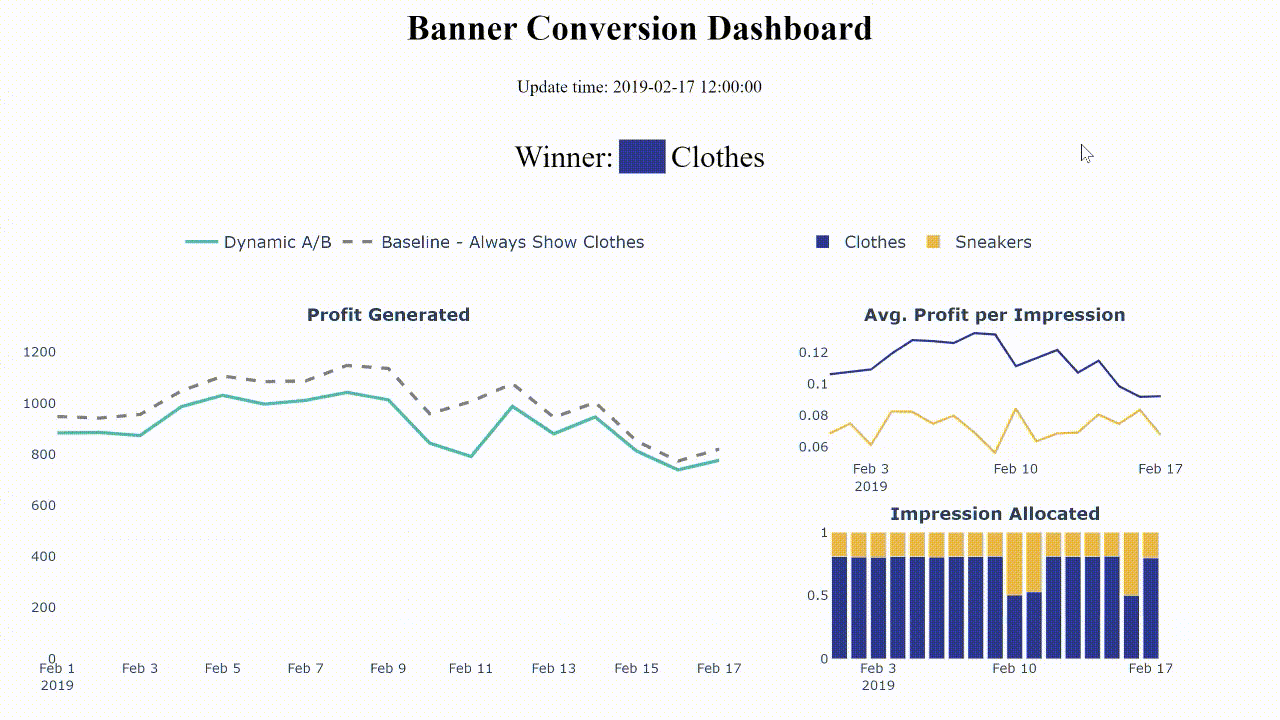

In [1]:
# !pip install dash
# !pip install jupyter-dash
import pandas as pd
import numpy as np
import datetime
import dash
from dash import dcc, html
import plotly
from dash.dependencies import Input, Output
from plotly import graph_objects as go 

df = pd.read_csv('raw_data.csv') # impression level data saved during the simulation
winners = pd.read_csv('winner_data.csv').set_index('timestep')['winner'] # winner data saved for each timestep

In [2]:
# Data processing
df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
df = df.set_index('date')
df['product'] = df['product'].str.capitalize()

In [3]:
# define the dashboard
app = dash.Dash(__name__)
app.layout = html.Div(
    html.Div([
        html.H1('Banner Conversion Dashboard', style={'text-align': 'center'}),
        html.Div(id='live-update-text'),
        dcc.Graph(id='live-update-graph'),
        dcc.Interval(
            id='interval-component',
            interval=1*1000, # updated each second
            n_intervals=0
        )
    ])
)
color = ['#2a3990', '#eab947']
banners = ['Clothes', 'Sneakers']

@app.callback(Output('live-update-text', 'children'),
              Input('interval-component', 'n_intervals'))
def update_timestep_winner(n):
    n = (n+12)*2-1
    current_time = datetime.datetime(2019,2,1) + datetime.timedelta(hours=12 * n)
    style = {'padding': '5px', 'fontSize': '16px','text-align': 'center'}
    style_winner = {'padding': '5px', 'fontSize': '28px','text-align': 'center'}
    style_color_block = {'background-color': color[winners.loc[n]],
                         'color': color[winners.loc[n]],
                         'fontSize': '28px',
                         'text-align': 'center'}
    winner = banners[winners.loc[n]]
    
    return [
        html.P('Update time: {}\n'.format(current_time.strftime('%Y-%m-%d %H:%M:%S')), style=style),
        html.P([
        html.Span('Winner:'.format(winner), style=style_winner),
        html.Span('___', style=style_color_block),
        html.Span('{}'.format(winner), style=style_winner)
            ], style=style_winner
        )
    ]

@app.callback(Output('live-update-graph', 'figure'),
              Input('interval-component', 'n_intervals'))
def update_graph_live(n):
    n = (n+12)*2-1
    # Summarize the data for visualization
    current_data = df[(df['timestep']>=n-40) & (df['timestep']<=n)]
    half_half = current_data.resample('1D')['target'].count() * current_data.groupby('banner').resample('1D')['target'].mean().unstack(0).mean(1)
    all_0 = current_data.resample('1D')['target'].count() * current_data[current_data['banner']==0].resample('1D')['target'].mean()
    returns = current_data.resample('1D')['target'].sum()
    impressions = current_data.groupby(['banner','product']).resample('1D')['target'].count() / current_data.resample('1D')['target'].count()
    per_impression = current_data.groupby(['banner','product']).resample('1D')['target'].mean()
    
    # Create the graph with subplots
    fig = plotly.tools.make_subplots(rows=2, cols=2, vertical_spacing=0.2,
                                     specs=[[{"type": "scatter", "rowspan": 2}, {"type": "scatter"}],
                                            [            None                 , {"type": "bar"}]],
                                     subplot_titles=['<b>Profit Generated</b>',
                                                     '<b>Avg. Profit per Impression</b>',
                                                     '<b>Impression Allocated</b>'],
                                    column_width = [2,1])
    fig['layout']['margin'] = {
        'l': 30, 'r': 100, 'b': 30, 't': 30
    }
    fig['layout']['legend'] = {'x': 0.5, 'y': 1.2, \
                               'xanchor': 'center', 'yanchor': 'bottom', 
                               'orientation': 'h', 'font':{'size':15}}
    
    # Profit Generated - Dynamic A/B
    fig.add_trace(go.Scatter(x=returns.index,
                             y=returns.values,
                             showlegend=True,
                             mode='lines',
                             line={'color': '#52bab0','width':3},
                             name='Dynamic A/B'), 'all', 1)
    # Profit Generated - Baseline
    fig.add_trace(go.Scatter(x=all_0.index,
                             y=all_0.values,
                             showlegend=True,
                             mode='lines',
                             line={'dash':'dash','width':3, 'color':'grey'},
                             name='Baseline - Always Show Clothes                          '), 'all', 1)

    # Total impressions for each banner
    for i in range(2):
        fig.add_trace(go.Bar(x=impressions[i].index.levels[1],
                             y=impressions[i].values,
                             name=impressions[i].index.get_level_values('product')[0],
                             legendgroup=per_impression[i].index.get_level_values('product')[0],
                             marker={'color': color[i]}), 2, 2)
        
    # Profit per impression for each banner
    for i in range(2):
        fig.add_trace(go.Scatter(x=per_impression[i].index.levels[1],
                                 y=per_impression[i].values,
                                 name=per_impression[i].index.get_level_values('product')[0],
                                 legendgroup=per_impression[i].index.get_level_values('product')[0],
                                 mode='lines',
                                 line={'color':color[i]},
                                 showlegend=False), 1, 2)

    fig.update_layout(plot_bgcolor = "white", yaxis1={'range':(0,1300)}, barmode='relative')

    return fig

In [4]:
# run the dashboard. This will host the dashboard on local machine.
# After running this code, the dashboard is accessible by the link
app.run_server()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
